In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics
from collections import Counter
import re
#NLTK

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
print(tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
2.2.0


In [4]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danjtchen","key":"f261c89bb65b6d6f826a2b37218bb407"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d kazanova/sentiment140

 96% 78.0M/80.9M [00:01<00:00, 34.5MB/s]
100% 80.9M/80.9M [00:01<00:00, 45.4MB/s]


In [7]:
! unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [8]:
!ls

kaggle.json  sentiment140.zip
sample_data  training.1600000.processed.noemoticon.csv


In [9]:
sentiment140 = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',header=None)
sentiment140.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
header= ['target','id','date','flag','user','text']
sentiment140.set_axis(header,axis=1,inplace=True)
sentiment140=sentiment140.drop(['id','date','flag','user'],axis=1)

In [11]:
sentiment140.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [12]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

sentiment140.target = sentiment140.target.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Labels distribuition')

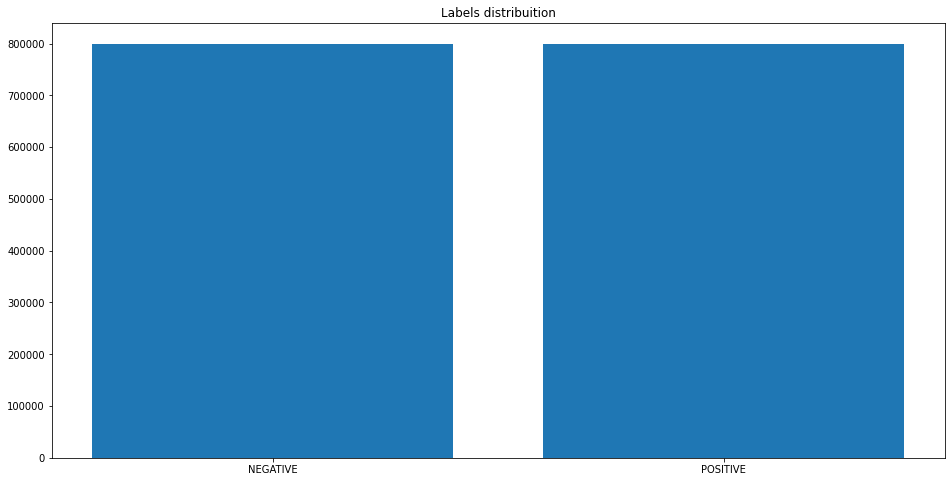

In [13]:
target_cnt = Counter(sentiment140.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Labels distribuition")

In [14]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
text_remove = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_remove, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [16]:
sentiment140.text = sentiment140.text.apply(lambda x: preprocess(x))

In [17]:
df_train, df_test = train_test_split(sentiment140, test_size=0.1, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1440000
TEST size: 160000


In [18]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 313288


In [19]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
x_test = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

In [20]:
labels = df_train.target.unique().tolist()
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1440000, 1)
y_test (160000, 1)


In [21]:
batchsz = 512
data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
data = data.shuffle(10000).batch(batchsz,drop_remainder=True)

data_test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
data_test = data_test.batch(batchsz,drop_remainder=True)

In [22]:
class Simple_LSTM(keras.Model):
  def __init__(self,units):
      super(Simple_LSTM, self).__init__()
      
      self.state_0 = [tf.zeros([batchsz,units])]
      
      #total words , embedding lens
      self.embedding = layers.Embedding(total_words,embedding_len,input_length=300)
      
      self.layer_1 = layers.SimpleRNNCell(units,dropout=0.1)
      
      self.out = layers.Dense(1)
      


  def call(self, inputs, training=None):
    
      x = self.embedding(inputs)
       
      state_0 = self.state_0
      for word in tf.unstack(x,axis=1):
          out,state_1 = self.layer_1(word,state_0)
          state_0 = state_1
      x = self.out(out)
      prob = tf.sigmoid(x)

      return prob

In [23]:
units = 128
epochs = 10
total_words=313288
embedding_len=128

rnn_model = Simple_LSTM(units)
rnn_model.compile(optimizer  =keras.optimizers.Adam(1e-4),loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])
rnn_model.fit(data,epochs=epochs, validation_data = data_test)

Epoch 1/10
2812/2812 [==============================] - 695s 247ms/step - loss: 0.5030 - accuracy: 0.7525 - val_loss: 0.4632 - val_accuracy: 0.7831
Epoch 2/10
2812/2812 [==============================] - 690s 246ms/step - loss: 0.4467 - accuracy: 0.7942 - val_loss: 0.4610 - val_accuracy: 0.7845
Epoch 3/10
2812/2812 [==============================] - 689s 245ms/step - loss: 0.4376 - accuracy: 0.8007 - val_loss: 0.4656 - val_accuracy: 0.7826
Epoch 4/10
2812/2812 [==============================] - 691s 246ms/step - loss: 0.4132 - accuracy: 0.8143 - val_loss: 0.4716 - val_accuracy: 0.7801
Epoch 5/10
2812/2812 [==============================] - 693s 246ms/step - loss: 0.3941 - accuracy: 0.8241 - val_loss: 0.4815 - val_accuracy: 0.7758
Epoch 6/10
2812/2812 [==============================] - 693s 246ms/step - loss: 0.3753 - accuracy: 0.8336 - val_loss: 0.4997 - val_accuracy: 0.7709
Epoch 7/10
2812/2812 [==============================] - 690s 245ms/step - loss: 0.3529 - accuracy: 0.8448 - val_